In [33]:
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
from torch.fft import fft2, fftshift
from torchmetrics.image import PeakSignalNoiseRatio

### Load Test Images

In [34]:
path = "/home/jakobtroidl/Desktop/diffusion-em/results/hemibrain_volume_benchmark_avg_pooling/15548_15559_15781/0_20.078.png"
pred = torch.from_numpy(cv2.imread(path, cv2.IMREAD_GRAYSCALE))
pred = pred.to(dtype=torch.float32)
pred = pred / 255.0

# rotate and flip image vertically
pred = torch.rot90(pred, k=1)
pred = torch.flip(pred, [0])

path = "/home/jakobtroidl/Desktop/neural-volumes/logs/cf_psnr/gt_0.png"
gt = torch.from_numpy(cv2.imread(path, cv2.IMREAD_GRAYSCALE))
gt = gt.to(dtype=torch.float32)
gt = gt / 255.0

### Display Images

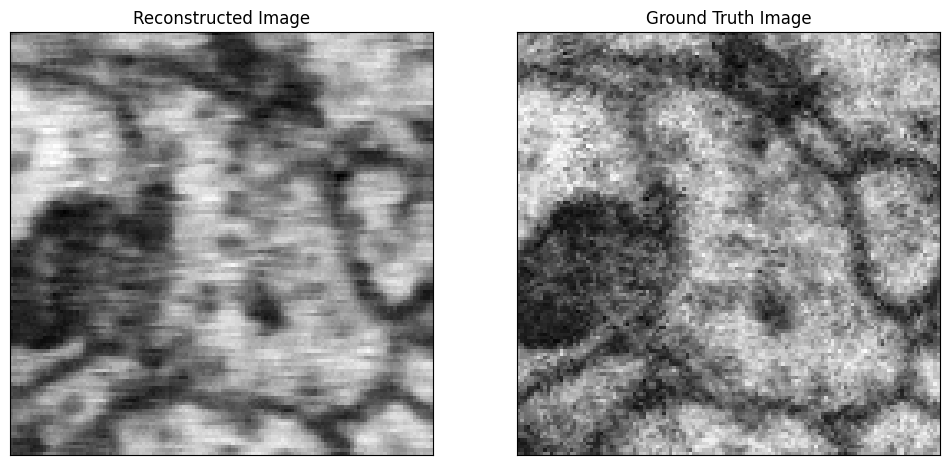

In [35]:
# Display the original, denoised images, and the difference
plt.figure(figsize=(12, 6))
plt.subplot(121), plt.imshow(pred.squeeze().cpu().detach().numpy(), cmap='gray')
plt.title('Reconstructed Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(gt.squeeze().cpu().detach().numpy(), cmap='gray')
plt.title('Ground Truth Image'), plt.xticks([]), plt.yticks([])
plt.show()

### Compute MSE in Spatial Domain

In [36]:
loss = nn.MSELoss()
spatial_mse = loss(pred, gt)
print("MSE Loss in the spatial domain: {}".format(spatial_mse))

MSE Loss in the spatial domain: 0.00982287060469389


### Confirm Parceval's theorem (Eq. 4 in paper)

In [37]:
fourier_pred = fft2(pred)
fshift_pred = fftshift(fourier_pred)
mag_pred = torch.abs(fshift_pred)
parcival_fourier = torch.sum(mag_pred**2) / (pred.shape[0] * pred.shape[1])

mag_gt = torch.abs(pred)
parcival_gt = torch.sum(mag_gt**2)

print("Sum of coefficient magnitudes in Fourier Domain: {}".format(parcival_fourier))
print("Sum of coffectient magnitudes in Spatial Domain: {}".format(parcival_gt))

Sum of coefficient magnitudes in Fourier Domain: 5016.31689453125
Sum of coffectient magnitudes in Spatial Domain: 5016.3173828125


### Compute MSE in Fourier Domain

In [38]:
n_pixels = pred.shape[0] * pred.shape[1]
fourier_gt = fft2(gt)
fshift_gt = fftshift(fourier_gt)
mse = torch.mean(torch.abs(fshift_gt - fshift_pred) ** 2) / n_pixels
print("MSE in Fourier Domain: {}".format(mse))

MSE in Fourier Domain: 0.00982287060469389


In [39]:
class LowPassFilter(torch.nn.Module):
    def __init__(self, rows, cols) -> None:
        super(LowPassFilter, self).__init__()
        self.rows = rows
        self.cols = cols
    
    def forward(self, radius):
        crow, ccol = self.rows // 2 , self.cols // 2
        low_pass = torch.zeros((self.rows, self.cols), dtype=torch.uint8)

        # y, x = np.ogrid[:rows, :cols]
        x = torch.arange(0, self.cols).unsqueeze(0).expand(self.rows, self.cols)
        y = torch.arange(0, self.rows).unsqueeze(1).expand(self.rows, self.cols)

        mask_area = (x - ccol) ** 2 + (y - crow) ** 2 <= radius**2
        low_pass[mask_area] = 1
        return low_pass

class ClippedFourierPSNR(torch.nn.Module):
    def __init__(self, im_max=1.0, low_pass_radius=25, im_size=(128, 128)):
        super(ClippedFourierPSNR, self).__init__()
        self.im_max = torch.tensor(im_max)
        self.threshold = low_pass_radius
        self.low_pass = LowPassFilter(im_size[0], im_size[1])

    def forward(self, prediction, gt):
        n_pixels = prediction.shape[-1] * prediction.shape[-2]
        pred_fourier = fftshift(fft2(prediction)) * self.low_pass(self.threshold)
        gt_fourier = fftshift(fft2(gt)) * self.low_pass(self.threshold)
        sum_sq_error = torch.sum(torch.abs(pred_fourier - gt_fourier) ** 2)
        return 20 * torch.log10(self.im_max * n_pixels) - 10 * torch.log10(sum_sq_error)

In [40]:
psnr_metric = PeakSignalNoiseRatio(data_range=(0, 1))
psnr = psnr_metric(pred, gt)

print("Computing PSNR in Spatial Domain")
print("PSNR: {}".format(psnr))
print("----------------------------------------")

print("Computing PSNR in Clipped Fourier Domain")
cfPSNR_metric = ClippedFourierPSNR()
psnr = cfPSNR_metric(gt, pred)
print("PSNR: {}".format(psnr))

Computing PSNR in Spatial Domain
PSNR: 20.07761573791504
----------------------------------------
Computing PSNR in Clipped Fourier Domain
PSNR: 22.761940002441406
